## Generation of a (Fictitious) Dataset of Measurements in a Rolling Mill

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_rolling_mill_data(start_date="2023-10-01", num_days=7, freq_minutes=1):
    """
    Gera um dataset fictício de sensores e KPIs de uma laminadora.

    Argumentos:
    start_date (str): Data de início no formato 'YYYY-MM-DD'.
    num_days (int): Número de dias para simular.
    freq_minutes (int): Frequência das medições em minutos.

    Retorna:
    pd.DataFrame: Um DataFrame com os dados simulados.
    """

    print(f"Gerando {num_days} dias de dados com frequência de {freq_minutes} min...")

    # 1. Configuração do Tempo e Estados da Máquina

    end_date = pd.to_datetime(start_date) + pd.Timedelta(days=num_days)
    freq = f"{freq_minutes}min"

    # Criar o índice de tempo
    timestamps = pd.date_range(start=start_date, end=end_date, freq=freq)
    n_samples = len(timestamps)
    df = pd.DataFrame(data={"timestamp": timestamps})

    # Simular ciclos realistas de operação (Produzindo, Parada, Manutenção)
    # Ciclo: ~4h produzindo, ~30min parada (troca de bobina/setup), ~4h produzindo, ~1h manutenção
    # Duração de um ciclo completo em minutos: (4*60) + 30 + (4*60) + 60 = 570 minutos

    cycle_duration_template_min = (4 * 60) + 30 + (4 * 60) + 60

    # Definir o template do ciclo com nomes em inglês
    cycle_template = (
        ["Running"] * (4 * 60 // freq_minutes)
        + ["Stopped (Setup)"] * (30 // freq_minutes)
        + ["Running"] * (4 * 60 // freq_minutes)
        + ["Maintenance"] * (60 // freq_minutes)
    )

    # Ajustar a duração caso a frequência seja maior que 1 min
    cycle_duration = len(cycle_template)

    n_cycles = int(np.ceil(n_samples / cycle_duration))
    statuses = (cycle_template * n_cycles)[:n_samples]
    df["equipment_status"] = statuses

    # Criar máscaras booleanas para facilitar a simulação
    is_producing = df["equipment_status"] == "Running"
    is_setup = df["equipment_status"] == "Stopped (Setup)"
    is_maintenance = df["equipment_status"] == "Maintenance"

    # 2. Simulação de Sensores Físicos

    # Temperatura de Entrada (do tarugo/placa)
    df["entry_temp_C"] = 0.0
    df.loc[is_producing, "entry_temp_C"] = np.random.normal(
        loc=1150, scale=15, size=is_producing.sum()
    )

    # Velocidade de Laminação (RPM do cilindro)
    df["rolling_speed_rpm"] = 0.0
    df.loc[is_producing, "rolling_speed_rpm"] = np.random.normal(
        loc=80, scale=5, size=is_producing.sum()
    )

    # Força de Laminação (kN) - Correlacionada com a temperatura (mais quente, menos força)
    df["rolling_force_kN"] = 0.0
    force_base = np.random.normal(loc=20000, scale=1000, size=is_producing.sum())
    temp_effect = (df.loc[is_producing, "entry_temp_C"] - 1150) * 50  # Efeito inverso
    df.loc[is_producing, "rolling_force_kN"] = force_base - temp_effect

    # Vibração (mm/s) - Aumenta durante a produção e tem picos antes de falhas
    df["vibration_mm_s"] = np.random.uniform(0.1, 0.3, size=n_samples)  # Ruído base
    df.loc[is_producing, "vibration_mm_s"] += np.random.normal(
        loc=1.2, scale=0.3, size=is_producing.sum()
    )

    # Adicionar alguns picos de vibração (anomalias)
    n_anomalies = int(n_samples * 0.001)  # 0.1% de anomalias
    anomaly_indices = np.random.choice(
        df[is_producing].index, n_anomalies, replace=False
    )
    df.loc[anomaly_indices, "vibration_mm_s"] *= np.random.uniform(
        3, 5, size=n_anomalies
    )

    # Espessura de Saída (mm) - O principal indicador de qualidade
    target_thickness = 3.5
    df["exit_thickness_mm"] = 0.0
    # A espessura depende da força (mais força, mais fina) e velocidade (mais rápido, mais grossa)
    force_effect = (
        df.loc[is_producing, "rolling_force_kN"] - 20000
    ) / 15000  # Normalizado
    speed_effect = (df.loc[is_producing, "rolling_speed_rpm"] - 80) / 100  # Normalizado
    noise = np.random.normal(0, 0.015, size=is_producing.sum())

    df.loc[is_producing, "exit_thickness_mm"] = (
        target_thickness - force_effect + speed_effect + noise
    )
    df["target_thickness_mm"] = target_thickness
    df.loc[~is_producing, "target_thickness_mm"] = 0

    # 3. Cálculo de Métricas (Qualidade, Produção, Desempenho)

    # Disponibilidade (Availability) - 1 se planejado para rodar E não em manutenção, 0 se em manutenção
    df["availability"] = 1.0
    df.loc[is_maintenance, "availability"] = 0.0

    # Desempenho (Performance) - (Velocidade Atual / Velocidade Máxima Teórica)
    # Assumindo que a velocidade máxima teórica é 100 RPM
    MAX_SPEED_RPM = 100.0
    df["performance"] = (df["rolling_speed_rpm"] / MAX_SPEED_RPM).clip(0, 1)
    df.loc[~is_producing, "performance"] = 0.0  # Desempenho é 0 se não está produzindo

    # Qualidade (Quality) - % de produtos dentro da tolerância
    # Tolerância: +/- 0.05mm
    TOLERANCE = 0.05
    df["thickness_deviation_mm"] = df["exit_thickness_mm"] - df["target_thickness_mm"]
    df["good_part"] = (np.abs(df["thickness_deviation_mm"]) <= TOLERANCE).astype(int)
    df.loc[~is_producing, "good_part"] = 0

    # Métrica de Qualidade (0-100%) - Usamos uma janela móvel para simular um "lote"
    # A qualidade instantânea é 'good_part', mas a "Qualidade" como KPI
    # é geralmente medida em uma janela (ex: última hora)
    df["quality"] = df.rolling(
        window=f"{60 // freq_minutes}T", min_periods=1, on="timestamp"
    )["good_part"].mean()
    df["quality"] = (df["quality"] * 100).fillna(0)
    df.loc[~is_producing, "quality"] = 0

    # Produção (Production) - (Material processado por minuto)
    # Assumindo uma largura de chapa e densidade, a produção é proporcional à velocidade
    TONS_PER_MIN_AT_MAX_SPEED = 1.5
    df["production_ton_min"] = (
        df["rolling_speed_rpm"] / MAX_SPEED_RPM
    ) * TONS_PER_MIN_AT_MAX_SPEED
    df.loc[~is_producing, "production_ton_min"] = 0.0

    # 4. Limpeza e Finalização

    # Preencher NaNs com 0 (ocorrem em sensores quando a máquina não está produzindo)
    cols_to_fill = [
        "entry_temp_C",
        "rolling_speed_rpm",
        "rolling_force_kN",
        "vibration_mm_s",
        "exit_thickness_mm",
        "thickness_deviation_mm",
    ]
    df[cols_to_fill] = df[cols_to_fill].replace(
        0.0, np.nan
    )  # Garante que apenas os '0' que geramos sejam preenchidos
    df.loc[is_producing, cols_to_fill] = df.loc[is_producing, cols_to_fill].fillna(
        method="ffill"
    )  # Propagação fwd
    df = df.fillna(0.0)  # Preenche o resto (paradas) com 0

    # Arredondar para realismo
    df = df.round(
        {
            "entry_temp_C": 1,
            "rolling_speed_rpm": 2,
            "rolling_force_kN": 0,
            "vibration_mm_s": 3,
            "exit_thickness_mm": 4,
            "thickness_deviation_mm": 4,
            "quality": 1,
            "production_ton_min": 2,
            "performance": 2,
        }
    )

    # Reordenar colunas
    col_order = [
        "timestamp",
        "equipment_status",
        # Métricas Chave (Solicitadas)
        "quality",
        "production_ton_min",
        "performance",
        "availability",
        # Sensores Físicos (Criativos)
        "rolling_speed_rpm",
        "rolling_force_kN",
        "vibration_mm_s",
        "entry_temp_C",
        "exit_thickness_mm",
        "target_thickness_mm",
        "thickness_deviation_mm",
    ]

    return df[col_order]

Gerando 93 dias de dados com frequência de 1 min...

Informações do DataFrame (DataFrame Info)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133921 entries, 0 to 133920
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               133921 non-null  datetime64[ns]
 1   equipment_status        133921 non-null  object        
 2   quality                 133921 non-null  float64       
 3   production_ton_min      133921 non-null  float64       
 4   performance             133921 non-null  float64       
 5   availability            133921 non-null  float64       
 6   rolling_speed_rpm       133921 non-null  float64       
 7   rolling_force_kN        133921 non-null  float64       
 8   vibration_mm_s          133921 non-null  float64       
 9   entry_temp_C            133921 non-null  float64       
 10  exit_thickness_mm       133921 non-null  float64       
 

/tmp/ipykernel_10071/337485087.py:125: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df["quality"] = df.rolling(
/tmp/ipykernel_10071/337485087.py:153: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[is_producing, cols_to_fill] = df.loc[is_producing, cols_to_fill].fillna(


,timestamp,equipment_status,quality,production_ton_min,performance,availability,rolling_speed_rpm,rolling_force_kN,vibration_mm_s,entry_temp_C,exit_thickness_mm,target_thickness_mm,thickness_deviation_mm
0,2023-11-01 00:00:00,Running,100.0,1.13,0.75,1.0,75.22,19833.0,1.728,1147.5,3.4617,3.5,-0.0383
1,2023-11-01 00:01:00,Running,50.0,1.23,0.82,1.0,81.80,22440.0,1.668,1129.1,3.3689,3.5,-0.1311
2,2023-11-01 00:02:00,Running,33.3,1.09,0.72,1.0,72.42,19524.0,1.417,1173.4,3.4410,3.5,-0.0590
3,2023-11-01 00:03:00,Running,50.0,1.16,0.77,1.0,77.10,19914.0,1.205,1165.0,3.4870,3.5,-0.0130
4,2023-11-01 00:04:00,Running,40.0,1.30,0.86,1.0,86.47,18380.0,1.433,1136.8,3.6748,3.5,0.1748
5,2023-11-01 00:05:00,Running,33.3,1.21,0.81,1.0,80.80,18093.0,1.485,1163.5,3.6336,3.5,0.1336
6,2023-11-01 00:06:00,Running,28.6,1.20,0.80,1.0,80.12,18830.0,1.886,1150.2,3.5879,3.5,0.0879
7,2023-11-01 00:07:00,Running,37.5,1.27,0.84,1.0,84.35,20505.0,1.522,1140.4,3.4993,3.5,-0.0007
8,2023-11-01 00:08:00,Running,44.4,1.16,0.77,1.0,77.08,20374.0,1.580,1156.0,3.4602,3.5,-0.0398
9,2023-11-01 00:09:00,Running,40.0,1.24,0.83,1.0,82.92,18389.0,1.578,1174.6,3.6362,3.5,0.1362



Estatísticas Descritivas (Describe)


,timestamp,quality,production_ton_min,performance,availability,rolling_speed_rpm,rolling_force_kN,vibration_mm_s,entry_temp_C,exit_thickness_mm,target_thickness_mm,thickness_deviation_mm
count,133921,133921.000000,133921.000000,133921.000000,133921.000000,133921.000000,133921.000000,133921.000000,133921.000000,133921.000000,133921.000000,133921.000000
mean,2023-12-17 11:59:59.999999488,29.107289,1.010722,0.673816,0.894931,67.381545,16847.789936,1.214363,968.710757,2.947837,2.948007,-0.000170
min,2023-11-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038000,0.000000,0.000000,0.000000,-0.429600
25%,2023-11-24 06:00:00,20.000000,1.110000,0.740000,1.000000,73.860000,18455.000000,1.023000,1131.600000,3.378600,3.500000,-0.052900
50%,2023-12-17 12:00:00,35.000000,1.180000,0.790000,1.000000,78.810000,19707.000000,1.328000,1146.500000,3.476400,3.500000,0.000000
75%,2024-01-09 18:00:00,40.000000,1.240000,0.830000,1.000000,82.670000,20670.000000,1.564000,1158.200000,3.552300,3.500000,0.052300
max,2024-02-02 00:00:00,100.000000,1.540000,1.000000,1.000000,102.680000,25127.000000,9.608000,1223.000000,3.945300,3.500000,0.445300
std,NaN,15.784649,0.442765,0.295181,0.306644,29.517106,7380.551454,0.539986,419.404437,1.278776,1.275654,0.090359



Amostra de Dados (durante manutenção)


,timestamp,equipment_status,quality,production_ton_min,performance,availability,rolling_speed_rpm,rolling_force_kN,vibration_mm_s,entry_temp_C,exit_thickness_mm,target_thickness_mm,thickness_deviation_mm
510,2023-11-01 08:30:00,Maintenance,0.0,0.0,0.0,0.0,0.0,0.0,0.182,0.0,0.0,0.0,0.0
511,2023-11-01 08:31:00,Maintenance,0.0,0.0,0.0,0.0,0.0,0.0,0.255,0.0,0.0,0.0,0.0
512,2023-11-01 08:32:00,Maintenance,0.0,0.0,0.0,0.0,0.0,0.0,0.139,0.0,0.0,0.0,0.0
513,2023-11-01 08:33:00,Maintenance,0.0,0.0,0.0,0.0,0.0,0.0,0.174,0.0,0.0,0.0,0.0
514,2023-11-01 08:34:00,Maintenance,0.0,0.0,0.0,0.0,0.0,0.0,0.151,0.0,0.0,0.0,0.0



Amostra de Dados (durante produção)


,timestamp,equipment_status,quality,production_ton_min,performance,availability,rolling_speed_rpm,rolling_force_kN,vibration_mm_s,entry_temp_C,exit_thickness_mm,target_thickness_mm,thickness_deviation_mm
0,2023-11-01 00:00:00,Running,100.0,1.13,0.75,1.0,75.22,19833.0,1.728,1147.5,3.4617,3.5,-0.0383
1,2023-11-01 00:01:00,Running,50.0,1.23,0.82,1.0,81.80,22440.0,1.668,1129.1,3.3689,3.5,-0.1311
2,2023-11-01 00:02:00,Running,33.3,1.09,0.72,1.0,72.42,19524.0,1.417,1173.4,3.4410,3.5,-0.0590
3,2023-11-01 00:03:00,Running,50.0,1.16,0.77,1.0,77.10,19914.0,1.205,1165.0,3.4870,3.5,-0.0130
4,2023-11-01 00:04:00,Running,40.0,1.30,0.86,1.0,86.47,18380.0,1.433,1136.8,3.6748,3.5,0.1748



Gerando gráficos de visualização (Generating plots)...


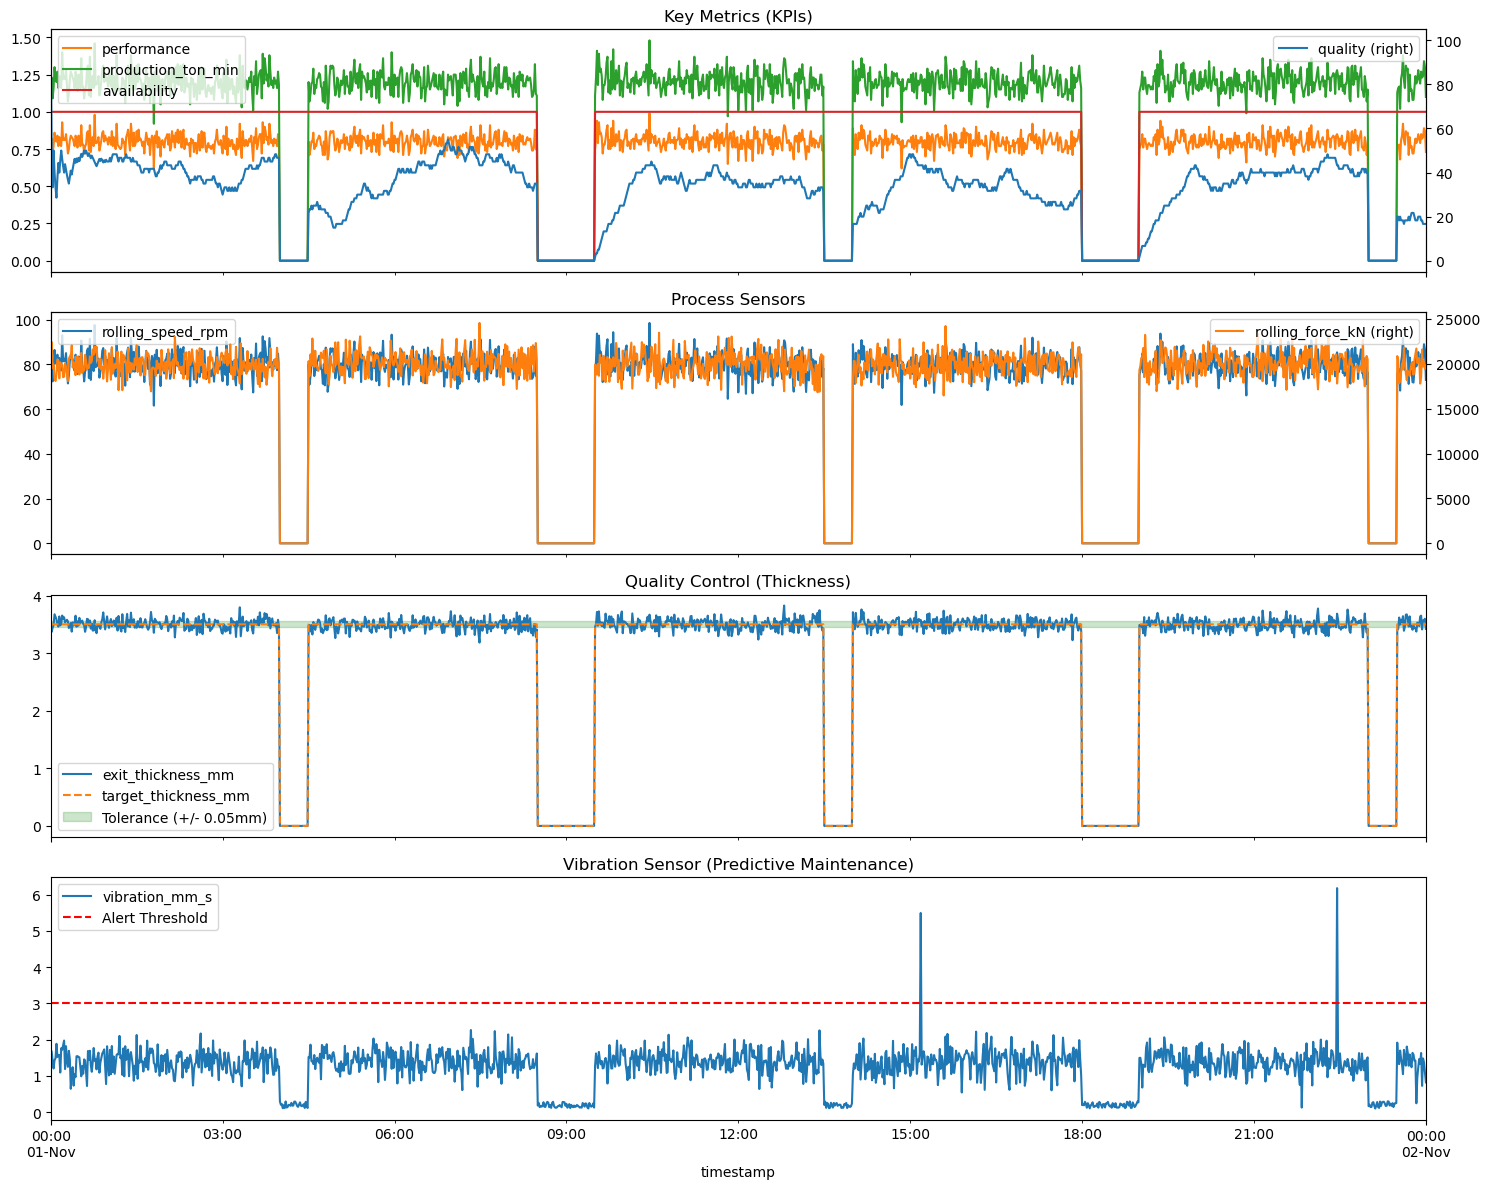

In [3]:
# Gerar 3 dias de dados com medições a cada 1 minuto
rolling_mill_df = generate_rolling_mill_data(
    start_date="2023-11-01", num_days=3*31, freq_minutes=1
)

print("\nInformações do DataFrame (DataFrame Info)")
rolling_mill_df.info()

print("\n10 Primeiras Linhas do Dataset (Head)")
display(rolling_mill_df.head(10))

print("\nEstatísticas Descritivas (Describe)")
display(rolling_mill_df.describe())

print("\nAmostra de Dados (durante manutenção)")
display(rolling_mill_df[rolling_mill_df["equipment_status"] == "Maintenance"].head())

print("\nAmostra de Dados (durante produção)")
display(rolling_mill_df[rolling_mill_df["equipment_status"] == "Running"].head())

# Plotar resultados para verificação
print("\nGerando gráficos de visualização (Generating plots)...")

# Selecionar 1 dia para plotar, para não ficar muito denso
plot_df = rolling_mill_df.set_index("timestamp").truncate(after="2023-11-02")

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 12), sharex=True)

# 1. KPIs
plot_df[["quality", "performance", "production_ton_min", "availability"]].plot(
    ax=axes[0], title="Key Metrics (KPIs)", secondary_y=["quality"]
)
axes[0].legend(loc="upper left")
axes[0].right_ax.legend(loc="upper right")  # Legenda do eixo Y secundário

# 2. Status e Sensores
plot_df[["rolling_speed_rpm", "rolling_force_kN"]].plot(
    ax=axes[1], title="Process Sensors", secondary_y=["rolling_force_kN"]
)
axes[1].legend(loc="upper left")
axes[1].right_ax.legend(loc="upper right")

# 3. Qualidade (Detalhe)
plot_df[["exit_thickness_mm", "target_thickness_mm"]].plot(
    ax=axes[2], title="Quality Control (Thickness)", style=["-", "--"]
)
# Plotar bandas de tolerância
axes[2].axhspan(
    3.5 - 0.05, 3.5 + 0.05, color="green", alpha=0.2, label="Tolerance (+/- 0.05mm)"
)
axes[2].legend()

# 4. Manutenção Preditiva (Vibração)
plot_df["vibration_mm_s"].plot(
    ax=axes[3], title="Vibration Sensor (Predictive Maintenance)"
)
axes[3].axhline(3.0, color="red", linestyle="--", label="Alert Threshold")
axes[3].legend()

plt.xlabel("Date/Time")
plt.tight_layout()

In [4]:
rolling_mill_df.to_excel("../rolling_mill-dataset.xlsx")